In [132]:
import pandas as pd
import numpy as np
import random
import nltk
import collections
import re
import math
import string
import gensim
import warnings
import pickle

from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from gensim import corpora, models, utils
from gensim.models.phrases import Phrases , Phraser

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [14]:
df = pd.read_csv('train.csv')
df['ngv_qlty_1'] = df['ngv_qlty_1'].astype('int32') 
df.head()

,id,text,ngv_qlty_1,ngv_qlty_2,ngv_qlty_3
0,000897889268bc93,REDIRECT Talk:Voydan Pop Georgiev- Chernodrinski,0,0,0
1,00173958f46763a2,TFD \n\nI think we just eced. I think we respo...,0,0,0
2,0034d7c78cfa6dee,"""\n\nChrist. """"IQ is selected for therefore ev...",0,0,0
3,003fa0c68deca750,Check the following websites:\n\nhttp://www.ir...,0,0,0
4,004a789c03eda830,Including some appropriate mention of the Solo...,0,0,0


## Postive negative label count in each class

In [119]:
df['ngv_qlty_3'].value_counts()

0    9672
1     328
Name: ngv_qlty_3, dtype: int64

In [16]:
df['ngv_qlty_2'].value_counts()

0    9625
1     375
Name: ngv_qlty_2, dtype: int64

In [17]:
df['ngv_qlty_1'].value_counts()

0    9231
1     769
Name: ngv_qlty_1, dtype: int64

In [18]:
# Function to remove stop words
def get_stopwords():
    
    stop_words = set(stopwords.words('english'))
    stop_words.update([x for x in ENGLISH_STOP_WORDS])

    return list(stop_words)

In [19]:
stop_words_list = get_stopwords()

In [120]:
# Function to clean the data
def clean_data(tweet):
    tokenizer = RegexpTokenizer(r'\w+')
    ps = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    
    raw = tweet.lower().strip()
    raw = re.sub(r"\s*http://www\.[a-z]+\.[a-z]+\s*", " ", raw) #weblink
    re.sub(r"\s*http://[a-z|\.|/]+\.htm\s*", " ", raw) #weblink
    re.sub(r"\s*[a-z]+@[a-z]+\.[a-z]+\s*", " ", raw) #email
    raw = raw.replace("\n", ".")
    
    sentence_list = re.split("\!+|\?+|;|:|\.+", raw)
    
    cleaned_tweet = ""
    for sentence in sentence_list:
        only_text = re.sub("[?|\.|0-9|\"]", " ", sentence)
        tokens = tokenizer.tokenize(only_text)
    
        lemma_tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
        # stemmed_tokens = [ps.stem(token) for token in tokens]
    
        # remove stop words from tokens
        stopped_tokens =  [token for token in lemma_tokens if not token in stop_words_list]
    
        clean_tokens = [token for token in stopped_tokens if len(token) > 1] # remove single character words
        
        if len(clean_tokens) > 0:
            cleaned_tweet += (" ".join(clean_tokens) + " ")
    
    cleaned_tweet = re.sub('[^a-z]+', ' ', cleaned_tweet) # remove all non alphabet characters
    return cleaned_tweet.strip()

In [42]:
# Bag Of Words model

def get_bow_model(X_train,Y_train): 

    pipeline = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()), 
                         ('clf-svm', SGDClassifier(loss='log', penalty='l2',alpha=1e-3, max_iter=50,
                                                   random_state=42, class_weight = {0:1, 1:14})),])
    
    tuned_parameters = [{'clf-svm__alpha': [1e-1,1e-2,1e-3],'clf-svm__max_iter':[30,50,70,90,120,150]}]
    text_clf_svm = GridSearchCV(pipeline, param_grid=tuned_parameters)
    
    text_clf_svm_model = text_clf_svm.fit(X_train, Y_train)
    # pickle.dump(text_clf_svm_model, open('bow_svm.sav', 'wb'))
    
    classifier = text_clf_svm_model.best_estimator_.named_steps['clf-svm']
    count_vect = text_clf_svm_model.best_estimator_.named_steps['vect']
    feat_names = count_vect.get_feature_names()
    
    return text_clf_svm_model, text_clf_svm, feat_names

In [58]:
# Accuracy matrix - 
# 1. Roc_auc_score, 
# 2. Confusion matrix, 
# 3. Classification report

def display_accuracy(pred, label_vector, model_name, data_type):
    print("The accuracy( " + data_type + " ) for the model " + model_name)
    print(roc_auc_score(label_vector, pred))
    print(confusion_matrix(label_vector, pred))
    print(classification_report(label_vector, pred))
    print("--------------------------------------------------------------\n\n")

In [44]:
# ROC curves

def plot_roc(actual, pred): 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [121]:
# Feature importance

def plot_model_weights(classifier, feature_names, top_features=50):
    coef = classifier.coef_.ravel()
    
    print("Total number of features are ", str(len(np.argsort(coef))))
    
    '''
    with open('features.txt', 'w') as f:
        for item in feature_names:
            f.write("%s\n" % item)
    f.close()
    '''
    
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['green' if c < 0 else 'red' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    
    pos_list = []
    neg_list = []
    
    neg_list = feature_names[np.argsort(coef)[-top_features:]].tolist()
    neg_list.reverse()
    neg_coeff = list(coef[top_positive_coefficients])
    neg_coeff.reverse()
             
    pos_list = feature_names[np.argsort(coef)[:top_features]].tolist()
    pos_coeff = list(coef[top_negative_coefficients])
        
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    return pos_list,neg_list

### Sanity check

In [116]:
df['pre_clean_len'] = [len(t) for t in df['text']]

## Cleaning Tweets

In [36]:
df['cleaned_tweet'] = df.apply(lambda row : clean_data(row['text']), axis=1)

In [37]:
df.head()

,id,text,ngv_qlty_1,ngv_qlty_2,ngv_qlty_3,cleaned_tweet
0,000897889268bc93,REDIRECT Talk:Voydan Pop Georgiev- Chernodrinski,0,0,0,redirect talk voydan pop georgiev chernodrinski
1,00173958f46763a2,TFD \n\nI think we just eced. I think we respo...,0,0,0,tfd think eced think responded seeing response...
2,0034d7c78cfa6dee,"""\n\nChrist. """"IQ is selected for therefore ev...",0,0,0,christ iq selected population ha iq cease amaze
3,003fa0c68deca750,Check the following websites:\n\nhttp://www.ir...,0,0,0,check following website personality farabi far...
4,004a789c03eda830,Including some appropriate mention of the Solo...,0,0,0,including appropriate mention solomon article ...


In [117]:
df['post_clean_len'] = [len(t) for t in df['cleaned_tweet']]

## Post cleaning

In [124]:
df.head()

,id,text,ngv_qlty_1,ngv_qlty_2,ngv_qlty_3,cleaned_tweet,pre_clean_len,post_clean_len
0,000897889268bc93,REDIRECT Talk:Voydan Pop Georgiev- Chernodrinski,0,0,0,redirect talk voydan pop georgiev chernodrinski,48,47
1,00173958f46763a2,TFD \n\nI think we just eced. I think we respo...,0,0,0,tfd think eced think responded seeing response...,198,84
2,0034d7c78cfa6dee,"""\n\nChrist. """"IQ is selected for therefore ev...",0,0,0,christ iq selected population ha iq cease amaze,109,47
3,003fa0c68deca750,Check the following websites:\n\nhttp://www.ir...,0,0,0,check following website personality farabi far...,177,88
4,004a789c03eda830,Including some appropriate mention of the Solo...,0,0,0,including appropriate mention solomon article ...,96,59


## WordCloud

In [133]:
# all tweets 
all_words = " ".join(df['cleaned_tweet'])

In [134]:
#Hatred tweets class 3
hatred_words = " ".join(df[df['ngv_qlty_3']==1].cleaned_tweet)

(-0.5, 999.5, 999.5, -0.5)

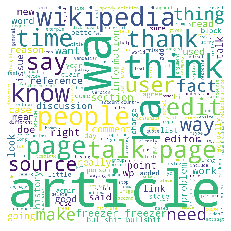

In [135]:
wordcloud = WordCloud(height=1000, width=1000, stopwords=STOPWORDS, background_color='white',)
wordcloud = wordcloud.generate(all_words)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 999.5, 999.5, -0.5)

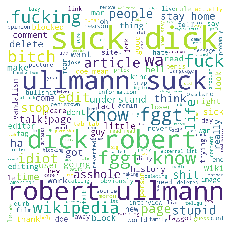

In [136]:
wordcloud = WordCloud(height=1000, width=1000, stopwords=STOPWORDS, background_color='white',)
wordcloud = wordcloud.generate(hatred_words)
plt.imshow(wordcloud)
plt.axis('off')

## Spilting the datset for three different classes

In [73]:
train_x1, test_x1, train_y1, test_y1 = train_test_split(df['cleaned_tweet'], df['ngv_qlty_1'], test_size=0.2)

In [74]:
train_x2, test_x2, train_y2, test_y2 = train_test_split(df['cleaned_tweet'], df['ngv_qlty_2'], test_size=0.2)

In [75]:
train_x3, test_x3, train_y3, test_y3 = train_test_split(df['cleaned_tweet'], df['ngv_qlty_3'], test_size=0.2)

## Training separately for each class

In [79]:
text_clf_svm_model_1, text_clf_svm1, feat_names1 = get_bow_model(train_x1, train_y1)

In [80]:
text_clf_svm_model_2, text_clf_svm2, feat_names2 = get_bow_model(train_x2, train_y2)

In [81]:
text_clf_svm_model_3, text_clf_svm3, feat_names3 = get_bow_model(train_x3, train_y3)

## Predictions and accruacy metrics for class 1 

The accuracy( Test_negative_1 ) for the model BOW-SVM
0.8278459111495599
[[1730   98]
 [  50  122]]
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      1828
         1.0       0.55      0.71      0.62       172

   micro avg       0.93      0.93      0.93      2000
   macro avg       0.76      0.83      0.79      2000
weighted avg       0.94      0.93      0.93      2000

--------------------------------------------------------------




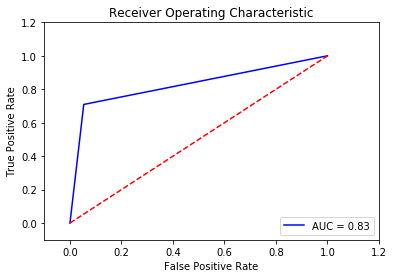

In [82]:
prediction = text_clf_svm1.predict(test_x1)
    
prediction = [float(i) for i in prediction]
actual = [float(i) for i in test_y1]
display_accuracy(prediction,actual,"BOW-SVM", "Test_negative_1")

plot_roc(actual,prediction)

## Predictions and accruacy metrics for class 2

The accuracy( Test_negative_2 ) for the model BOW-SVM
0.7961011946971385
[[1913   10]
 [  31   46]]
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1923
         1.0       0.82      0.60      0.69        77

   micro avg       0.98      0.98      0.98      2000
   macro avg       0.90      0.80      0.84      2000
weighted avg       0.98      0.98      0.98      2000

--------------------------------------------------------------




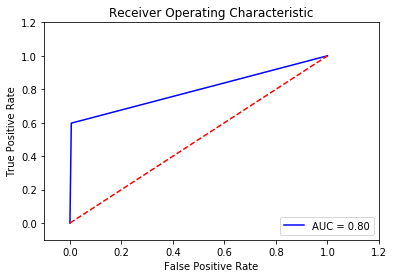

In [84]:
prediction = text_clf_svm2.predict(test_x2)
    
prediction = [float(i) for i in prediction]
actual = [float(i) for i in test_y2]
display_accuracy(prediction,actual,"BOW-SVM", "Test_negative_2")

plot_roc(actual,prediction)

## Predictions and accruacy metrics for class 3

The accuracy( Test_negative_3 ) for the model BOW-SVM
0.7116470723835869
[[1914   14]
 [  41   31]]
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1928
         1.0       0.69      0.43      0.53        72

   micro avg       0.97      0.97      0.97      2000
   macro avg       0.83      0.71      0.76      2000
weighted avg       0.97      0.97      0.97      2000

--------------------------------------------------------------




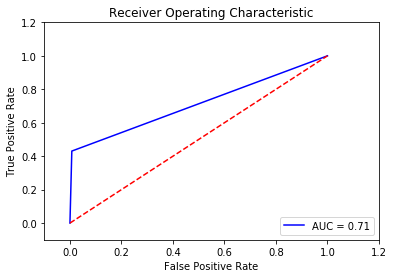

In [85]:
prediction = text_clf_svm3.predict(test_x3)
    
prediction = [float(i) for i in prediction]
actual = [float(i) for i in test_y3]
display_accuracy(prediction,actual,"BOW-SVM", "Test_negative_3")

plot_roc(actual,prediction)

## Top 30 negative and positive features for class 1

Total number of features are  27256


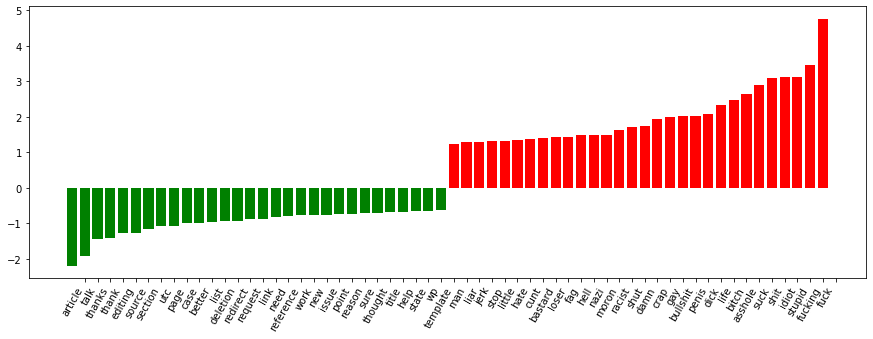

In [91]:
classifier = text_clf_svm_model_1.best_estimator_.named_steps['clf-svm']
pos_list, neg_list = plot_model_weights(classifier, feat_names1, 30)

## Top 30 negative and positive features for class 2

Total number of features are  27354


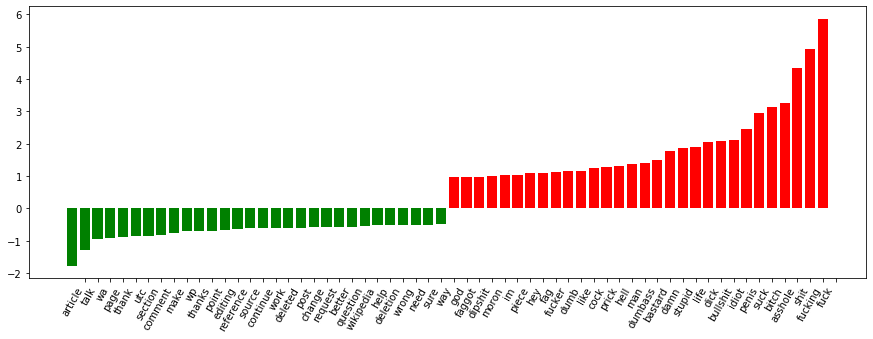

In [92]:
classifier = text_clf_svm_model_2.best_estimator_.named_steps['clf-svm']
pos_list, neg_list = plot_model_weights(classifier, feat_names2, 30)

## Top 30 negative and positive features for class 3

Total number of features are  26951


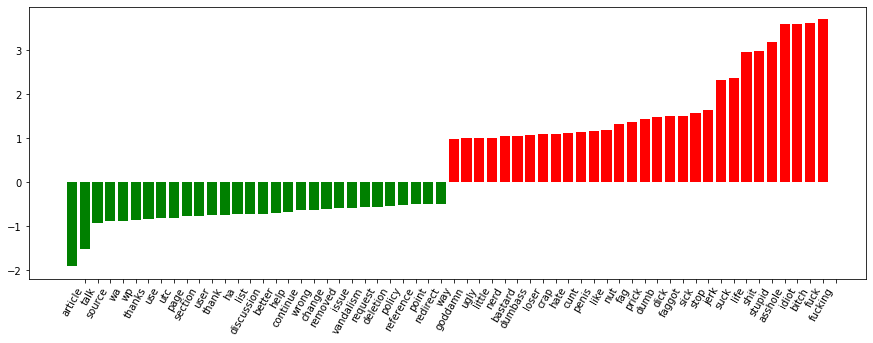

In [93]:
classifier = text_clf_svm_model_3.best_estimator_.named_steps['clf-svm']
pos_list, neg_list = plot_model_weights(classifier, feat_names3, 30)

## Predictions on test data

In [106]:
df_test = pd.read_csv('test.csv')
df_test['cleaned_tweet'] = df_test.apply(lambda row : clean_data(row['text']), axis=1)
df_test.head()

,id,text,cleaned_tweet
0,000b08c464718505,"""\n\n Regarding your recent edits \n\nOnce aga...",regarding recent edits read wp filmplot editin...
1,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,sorry sorry screwed talk page wa bad know temp...
2,006b888560bcdfcd,"""know the sex of the foetus""""""",know sex foetus
3,007810bde7d6ebd4,About Mitch moved to Yggdrasill \n\nI have no ...,mitch moved yggdrasill idea
4,00c438b052cc0f26,Appearance in historical fiction \n\nThe young...,appearance historical fiction young richard st...


## Running 3 different classifiers for each class

In [107]:
prediction_test1 = text_clf_svm1.predict(df_test['cleaned_tweet'])

In [108]:
prediction_test2 = text_clf_svm2.predict(df_test['cleaned_tweet'])

In [109]:
prediction_test3 = text_clf_svm3.predict(df_test['cleaned_tweet'])

In [110]:
df_test['prediction_ngv_qlty_1'] = prediction_test1
df_test.head()

,id,text,cleaned_tweet,prediction_ngv_qlty_1
0,000b08c464718505,"""\n\n Regarding your recent edits \n\nOnce aga...",regarding recent edits read wp filmplot editin...,0
1,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,sorry sorry screwed talk page wa bad know temp...,0
2,006b888560bcdfcd,"""know the sex of the foetus""""""",know sex foetus,1
3,007810bde7d6ebd4,About Mitch moved to Yggdrasill \n\nI have no ...,mitch moved yggdrasill idea,0
4,00c438b052cc0f26,Appearance in historical fiction \n\nThe young...,appearance historical fiction young richard st...,0


In [111]:
df_test['prediction_ngv_qlty_2'] = prediction_test2
df_test.head()

,id,text,cleaned_tweet,prediction_ngv_qlty_1,prediction_ngv_qlty_2
0,000b08c464718505,"""\n\n Regarding your recent edits \n\nOnce aga...",regarding recent edits read wp filmplot editin...,0,0
1,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,sorry sorry screwed talk page wa bad know temp...,0,0
2,006b888560bcdfcd,"""know the sex of the foetus""""""",know sex foetus,1,0
3,007810bde7d6ebd4,About Mitch moved to Yggdrasill \n\nI have no ...,mitch moved yggdrasill idea,0,0
4,00c438b052cc0f26,Appearance in historical fiction \n\nThe young...,appearance historical fiction young richard st...,0,0


## Predictions: all three classes

In [112]:
df_test['prediction_ngv_qlty_3'] = prediction_test3
df_test.head()

,id,text,cleaned_tweet,prediction_ngv_qlty_1,prediction_ngv_qlty_2,prediction_ngv_qlty_3
0,000b08c464718505,"""\n\n Regarding your recent edits \n\nOnce aga...",regarding recent edits read wp filmplot editin...,0,0,0
1,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,sorry sorry screwed talk page wa bad know temp...,0,0,0
2,006b888560bcdfcd,"""know the sex of the foetus""""""",know sex foetus,1,0,0
3,007810bde7d6ebd4,About Mitch moved to Yggdrasill \n\nI have no ...,mitch moved yggdrasill idea,0,0,0
4,00c438b052cc0f26,Appearance in historical fiction \n\nThe young...,appearance historical fiction young richard st...,0,0,0


In [113]:
df_test['prediction_ngv_qlty_1'].value_counts()

0    1781
1     219
Name: prediction_ngv_qlty_1, dtype: int64

In [114]:
df_test['prediction_ngv_qlty_2'].value_counts()

0    1955
1      45
Name: prediction_ngv_qlty_2, dtype: int64

In [115]:
df_test['prediction_ngv_qlty_3'].value_counts()

0    1958
1      42
Name: prediction_ngv_qlty_3, dtype: int64